In [1]:
import numpy as np
import os
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm

from scipy.io import loadmat 
from scipy.spatial import distance_matrix
from scipy.stats import ranksums, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression

import itertools
import pingouin as pg

In [2]:
plt.rcParams["font.family"] = "Arial" 
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

def stat_annot_h(ax, x1, x2, y, h, color="k", text=r"$\ast$"):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color, clip_on=False)
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color=color, clip_on=False)

## load analysis results

In [3]:
embed_dims = [2, 32]

In [4]:
mds_dist_dicts = {}
for d in embed_dims:
    mds_dist_dicts[str(d)] = np.load(f"../results/mds_dist_N2010_dim{d}.npz", allow_pickle=True)

In [5]:
mds_centered_dict = mds_dist_dicts["2"]["mds_centered"].item()
mds_dist_dict = mds_dist_dicts["32"]["mds_dist"].item()
mds_dist_min_dict = mds_dist_dicts["32"]["mds_dist_min"].item()
mds_dist_flatten_dict = mds_dist_dicts["32"]["mds_dist_flatten"].item()

In [6]:
training_methods = ["dino", "supervised"] 
depth_list = [4, 8, 12]
num_models = 6

## Gaze distance in MDS space

In [7]:
subj2subj_dist_data = np.load("../dataset/Nakano_etal_2010/preprocessed_data/subj2subj_dist.npz", allow_pickle=True)
subj2vit_dist_data = np.load("../dataset/Nakano_etal_2010/preprocessed_data/subj2vit_dist.npz", allow_pickle=True)

In [8]:
subj2subj_dist = subj2subj_dist_data['dist_mat']

In [9]:
subj2subj_mds_dist = {}
for d in embed_dims:
    embed = mds_dist_dicts[str(d)]["mds_centered"].item()["subj"]
    subj2subj_mds_dist[str(d)] = distance_matrix(embed, embed)
tril_idx = np.tril_indices(len(subj2subj_dist), k=-1)

In [10]:
subj2vit_mds_dist = {}
for d in embed_dims:
    embed_subj = mds_dist_dicts[str(d)]["mds_centered"].item()["subj"]
    subj2vit_mds_dist[str(d)] = {}
    for i, tm in enumerate(training_methods):
        subj2vit_mds_dist[str(d)][tm] = {}
        for j, depth in enumerate(depth_list):
            embed_vit = mds_dist_dicts[str(d)]["mds_centered"].item()[tm][str(depth)].reshape(-1, d)
            subj2vit_mds_dist[str(d)][tm][str(depth)] = distance_matrix(embed_subj, embed_vit)

In [11]:
"""
cmap = mpl.colormaps.get_cmap('Reds')
fig, axes = plt.subplots(2, 2, figsize=(4.5, 4))#, tight_layout=True)
axes[0, 0].set_title("Distance between\nparticipants")
axes[0, 1].set_title("Distance between\nparticipants and ViTs")
for i, d in enumerate(embed_dims):
    lr = LinearRegression(fit_intercept=False)
    x = subj2subj_dist[tril_idx].flatten()
    y = subj2subj_mds_dist[str(d)][tril_idx].flatten()
    lr.fit(x.reshape(-1, 1), y) 
    sns.histplot(x=x, y=y, bins=30, ax=axes[0], 
                 cmap=cmap, stat="density", alpha=0.8, rasterized=True)
    axes[0].text(10, 280, r"$\beta=$"+"{:.03f}".format(lr.coef_[0]), ha="left", va="center")
    axes[0].set_xlim(0, 300)
    axes[0].set_ylim(0, 300)
    axes[0].set_xticks([0, 150, 300])
    axes[0].set_yticks([0, 150, 300])
    axes[0].set_ylabel(f"Distance in MDS space\n ({d} dim.; N2010)")

for i in range(2):
    axes[1, i].set_xlabel("Actual distance\n(N2010)")
    for j in range(2):
        axes[j].axline((0, 0), slope=1, linestyle="dashed", alpha=0.8, color="k", zorder=0)
        axes[j].minorticks_on()
        axes[j].set_aspect('equal', 'box')

for i, d in enumerate(embed_dims):
    x_list, y_list = [], []
    for tm in training_methods:
        for depth in depth_list:
            x_list.append(subj2vit_dist_data[tm].item()[str(depth)][:,:,:,:6].flatten())
            y_list.append(subj2vit_mds_dist[str(d)][tm][str(depth)].flatten())
    x_list = np.hstack(x_list)
    y_list = np.hstack(y_list)
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(x_list.reshape(-1, 1), y_list) 
    axes[1].text(17, 467, r"$\beta=$"+"{:.03f}".format(lr.coef_[0]), ha="left", va="center")
    sns.histplot(x=x_list, y=y_list, bins=30, ax=axes[1], 
                 stat="density", cmap=cmap, alpha=0.8, rasterized=True)#, cbar=True)
    axes[1].set_xlim(0, 500)
    axes[1].set_ylim(0, 500)
    axes[1].set_xticks([0, 250, 500])
    axes[1].set_yticks([0, 250, 500])

cax = plt.axes([1, 0.45, 0.015, 0.2])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=cmap),
             cax=cax, orientation='vertical', label='Density', ticks=[0, 1]) #'# blocks / total blocks')
cb.ax.set_yticklabels(['Low', 'High']) 
plt.tight_layout()
plt.savefig("../figures/MDS_distance_regression.svg", dpi=300, bbox_inches='tight')
plt.show()
"""

'\ncmap = mpl.colormaps.get_cmap(\'Reds\')\nfig, axes = plt.subplots(2, 2, figsize=(4.5, 4))#, tight_layout=True)\naxes[0, 0].set_title("Distance between\nparticipants")\naxes[0, 1].set_title("Distance between\nparticipants and ViTs")\nfor i, d in enumerate(embed_dims):\n    lr = LinearRegression(fit_intercept=False)\n    x = subj2subj_dist[tril_idx].flatten()\n    y = subj2subj_mds_dist[str(d)][tril_idx].flatten()\n    lr.fit(x.reshape(-1, 1), y) \n    sns.histplot(x=x, y=y, bins=30, ax=axes[0], \n                 cmap=cmap, stat="density", alpha=0.8, rasterized=True)\n    axes[0].text(10, 280, r"$\x08eta=$"+"{:.03f}".format(lr.coef_[0]), ha="left", va="center")\n    axes[0].set_xlim(0, 300)\n    axes[0].set_ylim(0, 300)\n    axes[0].set_xticks([0, 150, 300])\n    axes[0].set_yticks([0, 150, 300])\n    axes[0].set_ylabel(f"Distance in MDS space\n ({d} dim.; N2010)")\n\nfor i in range(2):\n    axes[1, i].set_xlabel("Actual distance\n(N2010)")\n    for j in range(2):\n        axes[j].ax

## MDS embedding (2 dim)

/tmp/ipykernel_19430/1561360675.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


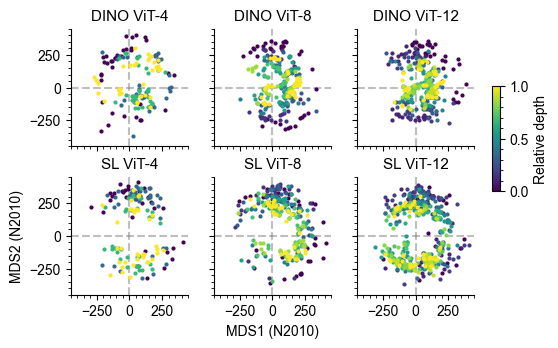

In [12]:
cmap = mpl.colormaps.get_cmap('viridis')
fig, axes = plt.subplots(2, 3, figsize=(5, 3.5), sharex='all', sharey='all')#, tight_layout=True)
for i, tm in enumerate(training_methods):
    for j, depth in enumerate(depth_list):
        if tm == "dino":
            tm_ = "DINO ViT-"
        else:
            tm_ = "SL ViT-"
        axes[i, j].set_title(f"{tm_}{depth}", fontsize=11)
        for dep in range(depth):
            x = mds_centered_dict[tm][str(depth)][:, dep, :, 0].flatten()
            y = mds_centered_dict[tm][str(depth)][:, dep, :, 1].flatten()
            axes[i, j].scatter(x, y, alpha=1, color=cmap(dep/(depth-1)), s=4, rasterized=True)#, label="head")
        pos = mds_centered_dict[tm][str(depth)]
        pos_flat = pos.reshape(-1, 2)
        axes[i, j].axvline(x=0, linestyle="dashed", alpha=0.5, color="tab:gray", zorder=-1)
        axes[i, j].axhline(y=0, linestyle="dashed", alpha=0.5, color="tab:gray", zorder=-1)
        axes[i, j].set_aspect("equal", adjustable="box")
        axes[i, j].set_xlim(-450, 450)
        axes[i, j].set_ylim(-450, 450)
        axes[i, j].minorticks_on()

cax = plt.axes([1, 0.45, 0.015, 0.3])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=cmap),
             cax=cax, orientation='vertical', label='Relative depth') #'# blocks / total blocks')
cb.ax.minorticks_on()
axes[1, 1].set_xlabel("MDS1 (N2010)")
axes[1, 0].set_ylabel("MDS2 (N2010)")
plt.tight_layout()
plt.savefig("../figures/MDS_vit_all_heads.svg", dpi=300, bbox_inches='tight')
plt.show()

## Group comparison of MDS distance

In [13]:
subj_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/goodsubj_gaze_pos.npz", allow_pickle=True)

In [14]:
gr_goodsubj = subj_gaze_pos["gr_goodsubj"]
group_name = subj_gaze_pos["group_name"]

In [15]:
# Subjects
mds_dist_groups_dict = {}
gr_idx = [0, 1, 4, 3]
for i in gr_idx:
    mds_dist_groups_dict[group_name[i]] = mds_dist_dict["subj"][gr_goodsubj == i]

# ViTs
for tm in training_methods:
    for depth in depth_list:
        top5 = np.sort(mds_dist_dict[tm][str(depth)].reshape(6, -1), axis=1)[:, :5].flatten()
        mds_dist_groups_dict[f"{tm}_{depth}"] = top5
        #mds_dist_groups_dict[f"{tm}_{depth}"] = mds_dist_min_dict[tm][str(depth)]
        
    top5 = np.sort(mds_dist_dict[f"{tm}_deit_small16"].flatten())[:5]
    mds_dist_groups_dict[f"{tm}_deit_small16"] = top5 #mds_dist_min_dict[f"{tm}_deit_small16"]
        
# GBVS
mds_dist_groups_dict["gbvs"] = mds_dist_dict["gbvs"]

In [16]:
df_mds_dist_groups = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in mds_dist_groups_dict.items()]))
df_mds_dist_groups = df_mds_dist_groups.drop([f"{tm}_deit_small16" for tm in training_methods], axis=1)

In [17]:
df_mds_dist_groups = df_mds_dist_groups.rename(
    columns={'adult control': 'TD adults', 'child control': 'TD children',
             'adult autistic': 'ASD adults', 'child autistic': 'ASD children',
             'dino_4': 'DINO ViT-4', 'dino_8': 'DINO ViT-8', 'dino_12': 'DINO ViT-12', 
             'supervised_4': 'SL ViT-4', 'supervised_8': 'SL ViT-8', 'supervised_12': 'SL ViT-12',
             'gbvs': 'GBVS'})

In [18]:
mds_saliency = df_mds_dist_groups["GBVS"].to_numpy()[:7]
saliency_labels = ["All", "Intensity", "Orientation", "Contrast", "Flicker", "Motion", "Color (DKL)"]

In [19]:
pairs = []
pairs_num = []
n_col = len(df_mds_dist_groups.columns)
for j in range(1, n_col):
    pairs.append((df_mds_dist_groups.columns[0], df_mds_dist_groups.columns[j]))
    pairs_num.append((0, j))
"""
for j in range(1, n_col):
    if j != 3:
        pairs.append((df_mds_dist_groups.columns[3], df_mds_dist_groups.columns[j]))
        pairs_num.append((3, j))    
"""

'\nfor j in range(1, n_col):\n    if j != 3:\n        pairs.append((df_mds_dist_groups.columns[3], df_mds_dist_groups.columns[j]))\n        pairs_num.append((3, j))    \n'

In [20]:
pairs

[('TD adults', 'TD children'),
 ('TD adults', 'ASD adults'),
 ('TD adults', 'ASD children'),
 ('TD adults', 'DINO ViT-4'),
 ('TD adults', 'DINO ViT-8'),
 ('TD adults', 'DINO ViT-12'),
 ('TD adults', 'SL ViT-4'),
 ('TD adults', 'SL ViT-8'),
 ('TD adults', 'SL ViT-12'),
 ('TD adults', 'GBVS')]

In [21]:
len(pairs)

10

In [22]:
def delete_nan(arr):
    return arr[~np.isnan(arr)]

In [23]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [24]:
p_values = []
for pair in pairs:
    s, p = mannwhitneyu(delete_nan(df_mds_dist_groups[pair[0]]), delete_nan(df_mds_dist_groups[pair[1]]), 
                        alternative="two-sided", method="exact")
    p_values.append(p)

In [25]:
"""
from scipy.stats import ttest_ind#(A, B, equal_var=False)
p_values = []
for pair in pairs:
    s, p = ttest_ind(delete_nan(df_mds_dist_groups[pair[0]]), delete_nan(df_mds_dist_groups[pair[1]]), 
                        alternative="two-sided", equal_var=False)
    p_values.append(p)
"""

'\nfrom scipy.stats import ttest_ind#(A, B, equal_var=False)\np_values = []\nfor pair in pairs:\n    s, p = ttest_ind(delete_nan(df_mds_dist_groups[pair[0]]), delete_nan(df_mds_dist_groups[pair[1]]), \n                        alternative="two-sided", equal_var=False)\n    p_values.append(p)\n'

In [26]:
p_values = np.array(p_values)

In [27]:
#reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='holm')
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='bonferroni')
#reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='fdr_bh') #'holm') 

In [28]:
indices = [i for i, x in enumerate(~reject) if x] # not significance indicces
ns_pairs = [pairs[i] for i in indices]
ns_pairs_num = [pairs_num[i] for i in indices]

In [29]:
for i, pair in enumerate(pairs):
    print(pair, pvals_corrected[i], convert_pvalue_to_asterisks(pvals_corrected[i]))

('TD adults', 'TD children') 0.003912348562692944 **
('TD adults', 'ASD adults') 0.0005083368545842357 ***
('TD adults', 'ASD children') 6.172741528490655e-10 ****
('TD adults', 'DINO ViT-4') 2.138315433529065e-09 ****
('TD adults', 'DINO ViT-8') 4.086814019554312e-05 ****
('TD adults', 'DINO ViT-12') 0.1003678465738716 ns
('TD adults', 'SL ViT-4') 1.4253754280521996e-15 ****
('TD adults', 'SL ViT-8') 9.977627996365397e-15 ****
('TD adults', 'SL ViT-12') 5.316650346634704e-13 ****
('TD adults', 'GBVS') 3.717737474198902e-06 ****


In [30]:
pair = pairs[4]
pg.compute_effsize(delete_nan(df_mds_dist_groups[pair[1]]),
                   delete_nan(df_mds_dist_groups[pair[0]]), 
                   paired=False, eftype='cohen')

np.float64(1.4255060553114893)

In [31]:
num_class = [4, 3, 3, 1]
num_group = np.sum(num_class)
group_ids = np.hstack([np.repeat(i, num_class[i]) for i in range(len(num_class))])
group_pos = np.arange(num_group) + group_ids * 0.5

In [32]:
df_mds_dist_groups_n = df_mds_dist_groups.copy()
df_mds_dist_groups_n.columns = group_pos
df_mds_dist_groups_melt = df_mds_dist_groups_n.melt()
df_mds_dist_groups_melt = df_mds_dist_groups_melt.dropna()

In [33]:
cmap_cb = sns.color_palette("colorblind")
#cmap = sns.color_palette("bright")
cmap = sns.color_palette("tab10")
#cmap = mpl.colormaps.get_cmap('tab10')

In [34]:
cmap_cb

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [35]:
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [36]:
subj_labels = ["TD adults", "TD children", "ASD adults", "ASD children"]
subj_colors = [cmap[3], cmap_cb[8], cmap[1], cmap[4]]
subj_markers = ["o", "^", "o", "^"]
model_labels = [["DINO ViT-4", "DINO ViT-8", "DINO ViT-12"], ["SL ViT-4", "SL ViT-8", "SL ViT-12"]]
model_colors = [[cmap_cb[9] for j in range(3)], [cmap_cb[2] for j in range(3)], [cmap_cb[7]]]
model_markers = ["P", "s", "D"]

In [37]:
color_list = subj_colors + list(itertools.chain.from_iterable(model_colors))

In [38]:
color_pal = {}
for i, key in enumerate(group_pos):
    color_pal[key] = color_list[i]

xo = np.arange(0, group_pos.max()+0.5, 0.5)

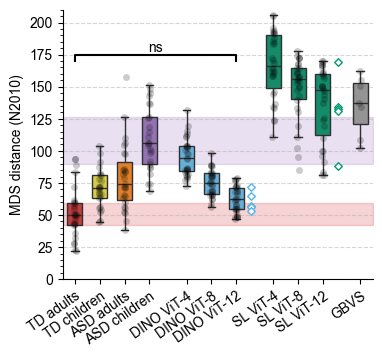

In [39]:
fig, ax = plt.subplots(figsize=(4, 3.5))
sns.boxplot(data=df_mds_dist_groups_melt, palette=color_pal, 
            x="variable", y="value", hue="variable", order=xo, showfliers=False, legend=False,
            width=1.2, ax=ax)
#vit_official_indices = df_mds_dist_groups_melt["value"].isin([mds_min_all_dist_dict[tm]["12"][-1] for tm in training_methods])
sns.stripplot(data=df_mds_dist_groups_melt, x="variable", y="value", color="k", 
              alpha=0.2, ax=ax, rasterized=False)

ax.scatter([14.2]*5, mds_dist_groups_dict["dino_deit_small16"][::-1], 
           fc="white", ec=model_colors[0][0],
           marker="D", label="Official ViT-12", alpha=1, s=15)
ax.scatter([21.2]*5, mds_dist_groups_dict["supervised_deit_small16"][::-1], 
           fc="white", ec=model_colors[1][0], 
           marker="D", label=" ",alpha=1, s=15)
#official = df_mds_dist_groups_melt[vit_official_indices].to_numpy()
#ax.scatter(official[:, 0]*2, official[:, 1], marker="P", color="tab:red", 
#           alpha=1, rasterized=True, zorder=999)
#ax.scatter(official[:, 0]*2, official[:, 1], marker="o", color="tab:red", 
#           alpha=1, s=20, rasterized=True, zorder=999)
"""
for i in range(len(group_pos)-1):
    ax.text(group_pos[i+1]*2, 170, convert_pvalue_to_asterisks(pvals_corrected[i]),
            fontsize=12, va="center", ha="center")
"""
ax.fill_between([-1, len(xo)], 
                np.percentile(df_mds_dist_groups["TD adults"].dropna().values, 25),
                np.percentile(df_mds_dist_groups["TD adults"].dropna().values, 75),
                color=color_list[0], alpha=0.2, label="TD adults IQR", zorder=-1)
ax.fill_between([-1, len(xo)], 
                np.percentile(df_mds_dist_groups["ASD children"].dropna().values, 25),
                np.percentile(df_mds_dist_groups["ASD children"].dropna().values, 75),
                color=color_list[3], alpha=0.2, label="ASD children IQR", zorder=-1)
for i, pair in enumerate(pairs_num):
    x1, x2 = pair
    y = 170
    h = 5
    text = convert_pvalue_to_asterisks(pvals_corrected[i])
    p = pvals_corrected[i]
    if p > 0.01:
        stat_annot_h(ax, group_pos[x1]*2, group_pos[x2]*2, y, h, color="k", text=text)
        #stat_annot_h(ax, group_pos[x1]*2, group_pos[x2]*2, y, h, color="k", text=r"$p=$"+f"{p:.4f}")
ax.set_xticks(ticks=group_pos*2)
ax.set_xticklabels(list(df_mds_dist_groups.columns), rotation=35, ha="right", rotation_mode='anchor')
ax.set_xlim(-1, len(xo))
ax.grid(linestyle='--', alpha=0.5, axis='y')
ax.set_ylabel("MDS distance (N2010)")
#ax.legend(ncol=2, handletextpad=0, columnspacing=1, prop={'size': 9}, labelspacing=0.1)
ax.set_xlabel("")
#for i in range(len(mds_saliency)):
#    ax.text(24, mds_saliency[i], saliency_labels[i], va="center", fontsize=9, rotation=35, rotation_mode='anchor')
ax.minorticks_on()
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.set_ylim(0, 210)
#ax.set_ylim(0, 170)
plt.savefig("../figures/MDS_boxplot_compare_groups_N2010.svg", dpi=300, bbox_inches="tight")

In [40]:
pairs = []
n_col = len(df_mds_dist_groups.columns)
for i in range(7,10):
    for j in range(4,7):
        pairs.append((df_mds_dist_groups.columns[i], df_mds_dist_groups.columns[j]))

In [41]:
pairs

[('SL ViT-4', 'DINO ViT-4'),
 ('SL ViT-4', 'DINO ViT-8'),
 ('SL ViT-4', 'DINO ViT-12'),
 ('SL ViT-8', 'DINO ViT-4'),
 ('SL ViT-8', 'DINO ViT-8'),
 ('SL ViT-8', 'DINO ViT-12'),
 ('SL ViT-12', 'DINO ViT-4'),
 ('SL ViT-12', 'DINO ViT-8'),
 ('SL ViT-12', 'DINO ViT-12')]

In [42]:
p_values = []
for pair in pairs:
    s, p = mannwhitneyu(delete_nan(df_mds_dist_groups[pair[0]]), delete_nan(df_mds_dist_groups[pair[1]]), 
                        alternative="two-sided", method="exact")
    p_values.append(p)

In [43]:
p_values

[np.float64(1.1330526707736975e-15),
 np.float64(1.691123389214474e-17),
 np.float64(1.691123389214474e-17),
 np.float64(3.024626606435152e-11),
 np.float64(5.073370167643422e-16),
 np.float64(1.691123389214474e-17),
 np.float64(8.229968969925224e-07),
 np.float64(1.240946343005581e-13),
 np.float64(1.691123389214474e-17)]

## Group comparison of MDS plot

In [44]:
vit_mds_min_pos_dict = {}
for tm in training_methods:
    for depth in depth_list:
        vit_mds_min_pos_dict[f"{tm}_{depth}"] = []
        for i in range(len(mds_dist_min_dict[tm][str(depth)])):
            m_idx, d_idx, h_idx = np.argwhere(mds_dist_dict[tm][str(depth)] == mds_dist_min_dict[tm][str(depth)][i])[0]
            vit_mds_min_pos_dict[f"{tm}_{depth}"].append(mds_centered_dict[tm][str(depth)][m_idx, d_idx, h_idx, :])
        vit_mds_min_pos_dict[f"{tm}_{depth}"] = np.array(vit_mds_min_pos_dict[f"{tm}_{depth}"])
    # official model
    d_idx, h_idx = np.argwhere(mds_dist_dict[f"{tm}_deit_small16"] == mds_dist_min_dict[f"{tm}_deit_small16"])[0]
    vit_mds_min_pos_dict[f"{tm}_deit_small16"] = mds_centered_dict[f"{tm}_deit_small16"][d_idx, h_idx, :]

In [45]:
def plot_mds(ax, mds_centered_dict, text=False, rasterized=True):
    for i, gi in enumerate(gr_idx):
        subj_mds_group = mds_centered_dict["subj"][gr_goodsubj == gi]
        if i > 1:
            ax.scatter(subj_mds_group[:, 0], subj_mds_group[:, 1], 
                       facecolor="white", edgecolor=subj_colors[i], marker=subj_markers[i], 
                       label=subj_labels[i], alpha=1, rasterized=rasterized)
        else:
            ax.scatter(subj_mds_group[:, 0], subj_mds_group[:, 1], 
                       color=subj_colors[i], marker=subj_markers[i], 
                       label=subj_labels[i], alpha=1, rasterized=rasterized)
            
    for i, tm in enumerate(training_methods):
        for j, depth in enumerate(depth_list):
            model_mds = vit_mds_min_pos_dict[f"{tm}_{depth}"]
            if depth == 12:
                ax.scatter(model_mds[:-1, 0], model_mds[:-1, 1],
                           color=model_colors[i][j], marker=model_markers[j], 
                           label=model_labels[i][j], alpha=1, rasterized=rasterized)            
                ax.scatter(model_mds[-1, 0], model_mds[-1, 1],
                           fc="white", ec=model_colors[i][j], marker="D", 
                           label="Official ViT-12", alpha=1, zorder=3)            
            else:
                ax.scatter(model_mds[:, 0], model_mds[:, 1],
                           color=model_colors[i][j], marker=model_markers[j], 
                           label=model_labels[i][j], alpha=1, rasterized=rasterized)                
    ax.scatter(mds_centered_dict["gbvs"][:, 0], mds_centered_dict["gbvs"][:, 1], marker="v", 
               color=cmap[7], label="GBVS", alpha=1, zorder=-1)
    if text:
        for k in range(len(saliency_labels)):
            ax.text(mds_centered_dict["gbvs"][k, 0], mds_centered_dict["gbvs"][k, 1], 
                    saliency_labels[k], ha="left", va="center", fontsize=9)
    ax.axvline(x=0, linestyle="dashed", alpha=0.5, color="k", zorder=-1)
    ax.axhline(y=0, linestyle="dashed", alpha=0.5, color="k", zorder=-1)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

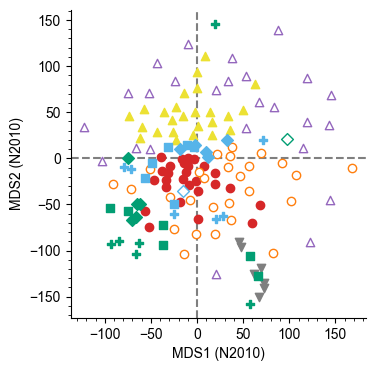

In [46]:
#fig, ax = plt.subplots(figsize=(8, 8))
fig, ax = plt.subplots(figsize=(4, 4))
plot_mds(ax, mds_centered_dict, text=False, rasterized=False)
"""
ta.allocate_text(fig,ax,gbvs_mds_centered[:, 0],gbvs_mds_centered[:, 1],
                 saliency_labels,
                 x_scatter=scatter_all[:, 0], y_scatter=scatter_all[:, 1],
                 textsize=9, margin=0.05,
                min_distance=0.005)
"""
ax.set_xlabel("MDS1 (N2010)")
ax.set_ylabel("MDS2 (N2010)")
#ax.invert_xaxis()
#ax.set_facecolor("#EAEAF2")
"""
x1, x2, y1, y2 = -50, 50, -50, 50  # subregion of the original image
axins = ax.inset_axes(
    [1.1, 0.02, 0.7, 0.7],
    xlim=(x1, x2), ylim=(y1, y2))
plot_mds(axins, text=False)
axins.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.3, 1.6), prop={'size': 9},
             handletextpad=0, columnspacing=0.5)
"""
#ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.0), prop={'size': 9},
#          handletextpad=0, columnspacing=0.5)
#ax.indicate_inset_zoom(axins, edgecolor="black")
fig.savefig("../figures/MDS_2d_N2010.svg", bbox_inches='tight', dpi=300)

## Layer comparison of MDS distance

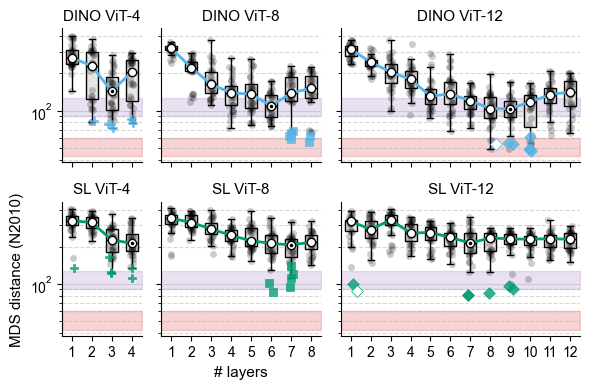

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), sharex='col', sharey='all', width_ratios=[1, 2, 3], tight_layout=True)
#fig.suptitle("All data")
for i, tm in enumerate(training_methods):
    for j, depth in enumerate(depth_list):
        dist_mat = mds_dist_flatten_dict[tm][str(depth)]
        #dist_mat_min = np.min(dist_mat, axis=2)
        columns = [str(d+1) for d in range(depth)]
        df = pd.DataFrame(dist_mat, columns=columns)#, columns=np.array2string(np.arange(1, depth+1)))
        df_melt = df.melt()
        vit_min_indices = df_melt["value"].isin(mds_dist_min_dict[tm][str(depth)])
        #vit_min_indices = df_melt["value"].isin(mds_dist_groups_dict[f"{tm}_{depth}"])
        
        
        #sns.stripplot(data=df, jitter=True, linewidth=1, edgecolor='k', palette=colors[i], ax=axes[i, j])
        #axes[i, j].grid(linestyle='--', linewidth=1)
        dist_median = np.median(dist_mat, axis=0)
        dist_median_minidx = np.argmin(dist_median)
        #axes[i, j].arrow(dist_median_minidx, dist_mat[:, dist_median_minidx].max()+90, 0, -30, 
        #                 head_width=0.2, head_length=20, color="tab:red", zorder=999, clip_on=False)
        #sns.pointplot(data=df_melt, x="variable", y="value", estimator='median', ax=axes[i, j], 
        #              color=cmaps[i](0.2*(j+2)), errorbar=("pi", 50), linewidth=2, zorder=9)#showfliers=False, color="white", width=0.6, 
        #axes[i, j].scatter(np.arange(0, len(dist_median)), dist_median, color="white", marker="o", s=6, zorder=10)
        axes[i, j].scatter(dist_median_minidx, dist_median[dist_median_minidx], color="k", marker=".", s=10, zorder=11)

        sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color="0.9", width=0.6, 
                    ax=axes[i, j], linecolor="k")
        #sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color=model_colors[i][j], width=0.6, 
        #            ax=axes[i, j])
        axes[i, j].plot(np.arange(0, len(dist_median)), dist_median, color=model_colors[i][j], 
                        linewidth = 2.0, marker="o", ms=6, mec="k", mfc="white", zorder=10)
        sns.stripplot(data=df_melt[~vit_min_indices], x="variable", y="value", color="k", alpha=0.2, ax=axes[i, j], rasterized=False)
        axes[i, j].scatter(df_melt[vit_min_indices]["variable"].to_numpy().astype(float) -1 + (np.random.rand(num_models)-0.5)/3, 
                           df_melt[vit_min_indices]["value"].to_numpy().astype(float), 
                           marker=model_markers[j], facecolor=model_colors[i][j], linewidth=0.5, alpha=0.8, zorder=3, 
                           label="Model-best heads")
        official_min_idx = np.where(mds_dist_dict[f"{tm}_deit_small16"] == mds_dist_min_dict[f"{tm}_deit_small16"])[0]
        if j == 2:
            axes[i, j].scatter(official_min_idx+0.3, mds_dist_min_dict[f"{tm}_deit_small16"], 
                               ec=model_colors[i][j], fc="white", linewidth=0.5, marker="D", alpha=1, zorder=5, label="Official model-best heads")
        if tm == "dino":
            tm_ = "DINO ViT-"
        else:
            tm_ = "SL ViT-"
        axes[i, j].set_title(f"{tm_}{depth}", fontsize=11)
        #xes[i, j].axhline(subj_mean_dist, linestyle="dashed", color="tab:red", label="Dist. between subjects")
        #if i == 0 and j == 2:
        #    axes[i, j].legend()
        axes[i, j].minorticks_on()
        axes[i, j].grid(which='major', alpha=0.5, axis="y")
        axes[i, j].grid(which='minor', alpha=0.5, linestyle='--', axis="y")
        axes[i, j].xaxis.set_tick_params(which='minor', bottom=False)
        axes[i, j].set_yscale('log')
        #axes[i, j].set_ylim(20, )# 450)
        axes[i, j].set_xlim(-0.5, depth-0.5)
        axes[i, j].set_xlabel("")
        axes[i, j].set_ylabel("")

        axes[i, j].fill_between([-0.5, depth-0.5], 
                        np.percentile(df_mds_dist_groups["TD adults"].dropna().values, 25),
                        np.percentile(df_mds_dist_groups["TD adults"].dropna().values, 75),
                        color=color_list[0], alpha=0.2, label="TD adults IQR", zorder=-1)
        axes[i, j].fill_between([-0.5, depth-0.5], 
                        np.percentile(df_mds_dist_groups["ASD children"].dropna().values, 25),
                        np.percentile(df_mds_dist_groups["ASD children"].dropna().values, 75),
                        color=color_list[3], alpha=0.2, label="ASD children IQR", zorder=-1)
        
#axes[0, 2].legend(ncol=2, handletextpad=0, prop={'size': 9}, borderpad=0.3, labelspacing=0.1)
axes[1, 1].set_xlabel("# layers", fontsize=11)
axes[1, 0].set_ylabel("MDS distance (N2010)", fontsize=11)
plt.savefig("../figures/MDS_dist_layers_N2010.svg", dpi=300, bbox_inches="tight")
fig.show()

In [48]:
attn_cos_sim = np.load("../results/dino_vit_attention_cos_sim_N2010.npz", allow_pickle=True)

In [49]:
num_frames = 2327

In [50]:
blanks = np.hstack(
    [np.arange(140, 155), np.arange(311, 326), np.arange(538, 553), 
     np.arange(740, 772), np.arange(911, 926), np.arange(1094, 1123),
     np.arange(1319, 1334), np.arange(1651, 1666), np.arange(1835, 1850), 
     np.arange(1988, 2003), np.arange(2167, 2182), 2326])
no_blank_idx = list(set(np.arange(num_frames)) - set(blanks))

In [51]:
attn_cos_sim_dict = {}
for depth in depth_list:
    cos_sim_all = attn_cos_sim[str(depth)].transpose(1,2,0,3)
    cos_sim_all_mean = np.mean(cos_sim_all[no_blank_idx], axis=0)
    cos_sim_all_mean_ = cos_sim_all_mean.reshape(depth, -1)
    attn_cos_sim_dict[str(depth)] = cos_sim_all_mean_.T

In [52]:
from matplotlib.ticker import ScalarFormatter

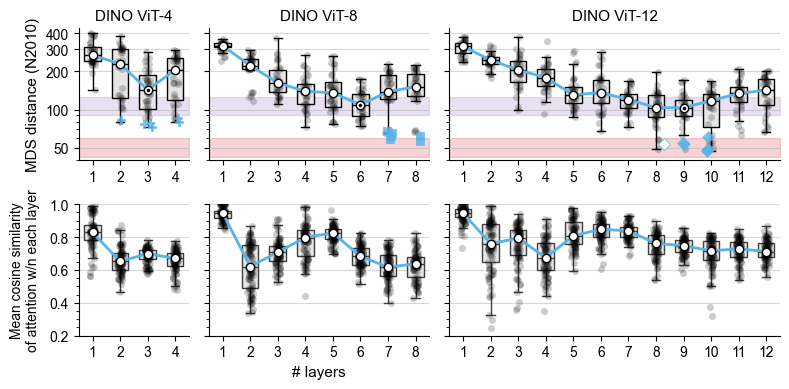

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4), sharey='row', width_ratios=[1, 2, 3], tight_layout=True)
#fig.suptitle("All data")
#for i, tm in enumerate(training_methods):
i = 0
tm = training_methods[0]
for j, depth in enumerate(depth_list):
    dist_mat = mds_dist_flatten_dict[tm][str(depth)]
    #dist_mat_min = np.min(dist_mat, axis=2)
    columns = [str(d+1) for d in range(depth)]
    df = pd.DataFrame(dist_mat, columns=columns)#, columns=np.array2string(np.arange(1, depth+1)))
    df_melt = df.melt()
    vit_min_indices = df_melt["value"].isin(mds_dist_min_dict[tm][str(depth)])
    #vit_min_indices = df_melt["value"].isin(mds_dist_groups_dict[f"{tm}_{depth}"])
    
    
    #sns.stripplot(data=df, jitter=True, linewidth=1, edgecolor='k', palette=colors[i], ax=axes[i, j])
    #axes[i, j].grid(linestyle='--', linewidth=1)
    dist_median = np.median(dist_mat, axis=0)
    dist_median_minidx = np.argmin(dist_median)
    #axes[i, j].arrow(dist_median_minidx, dist_mat[:, dist_median_minidx].max()+90, 0, -30, 
    #                 head_width=0.2, head_length=20, color="tab:red", zorder=999, clip_on=False)
    #sns.pointplot(data=df_melt, x="variable", y="value", estimator='median', ax=axes[i, j], 
    #              color=cmaps[i](0.2*(j+2)), errorbar=("pi", 50), linewidth=2, zorder=9)#showfliers=False, color="white", width=0.6, 
    #axes[i, j].scatter(np.arange(0, len(dist_median)), dist_median, color="white", marker="o", s=6, zorder=10)
    axes[i, j].scatter(dist_median_minidx, dist_median[dist_median_minidx], color="k", marker=".", s=10, zorder=11)

    sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color="0.9", width=0.6, 
                ax=axes[i, j], linecolor="k")
    #sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color=model_colors[i][j], width=0.6, 
    #            ax=axes[i, j])
    axes[i, j].plot(np.arange(0, len(dist_median)), dist_median, color=model_colors[i][j], 
                    linewidth = 2.0, marker="o", ms=6, mec="k", mfc="white", zorder=10)
    sns.stripplot(data=df_melt[~vit_min_indices], x="variable", y="value", color="k", alpha=0.2, ax=axes[i, j], rasterized=False)
    axes[i, j].scatter(df_melt[vit_min_indices]["variable"].to_numpy().astype(float) -1 + (np.random.rand(num_models)-0.5)/3, 
                       df_melt[vit_min_indices]["value"].to_numpy().astype(float), 
                       marker=model_markers[j], facecolor=model_colors[i][j], linewidth=0.5, alpha=0.8, zorder=3, 
                       label="Model-best heads")
    official_min_idx = np.where(mds_dist_dict[f"{tm}_deit_small16"] == mds_dist_min_dict[f"{tm}_deit_small16"])[0]
    if j == 2:
        axes[i, j].scatter(official_min_idx+0.3, mds_dist_min_dict[f"{tm}_deit_small16"], 
                           ec=model_colors[i][j], fc="white", linewidth=0.5, marker="D", alpha=1, zorder=5, label="Official model-best heads")
    if tm == "dino":
        tm_ = "DINO ViT-"
    else:
        tm_ = "SL ViT-"
    axes[i, j].set_title(f"{tm_}{depth}", fontsize=11)
    #xes[i, j].axhline(subj_mean_dist, linestyle="dashed", color="tab:red", label="Dist. between subjects")
    #if i == 0 and j == 2:
    #    axes[i, j].legend()
    axes[i, j].minorticks_on()
    axes[i, j].grid(which='major', alpha=0.5, axis="y")
    #axes[i, j].grid(which='minor', alpha=0.5, linestyle='--', axis="y")
    axes[i, j].xaxis.set_tick_params(which='minor', bottom=False)
    axes[i, j].set_yscale('log')
    #axes[i, j].set_ylim(20, )# 450)
    axes[i, j].set_xlim(-0.5, depth-0.5)
    axes[i, j].set_ylim(40, )
    axes[i, j].set_xlabel("")
    axes[i, j].set_ylabel("")
    axes[i, j].fill_between([-0.5, depth-0.5], 
                    np.percentile(df_mds_dist_groups["TD adults"].dropna().values, 25),
                    np.percentile(df_mds_dist_groups["TD adults"].dropna().values, 75),
                    color=color_list[0], alpha=0.2, label="TD adults IQR", zorder=-1)
    axes[i, j].fill_between([-0.5, depth-0.5], 
                    np.percentile(df_mds_dist_groups["ASD children"].dropna().values, 25),
                    np.percentile(df_mds_dist_groups["ASD children"].dropna().values, 75),
                    color=color_list[3], alpha=0.2, label="ASD children IQR", zorder=-1)        
#axes[0, 2].legend(ncol=2, handletextpad=0, prop={'size': 9}, borderpad=0.3, labelspacing=0.1)
axes[0,0].yaxis.set_major_formatter(ScalarFormatter())
axes[0,0].set_yticks([50, 100,200, 300, 400])
for i, depth in enumerate(depth_list):
    sns.boxplot(data=attn_cos_sim_dict[str(depth)], ax=axes[1, i], color="0.9", width=0.6, showfliers=False)
    sns.stripplot(data=attn_cos_sim_dict[str(depth)], ax=axes[1, i], color="k", alpha=0.2)
    med = np.median(attn_cos_sim_dict[str(depth)], axis=0)
    axes[1,i].plot(np.arange(0, len(med)), med, color=cmap_cb[9], 
                linewidth = 2.0, marker="o", ms=6, mec="k", mfc="white", zorder=10)
    #axes[i].axhline(0, linestyle="--", color="tab:gray")
    axes[1, i].set_xticks(np.arange(depth), np.arange(1, depth+1))
    axes[1,i].minorticks_on()
    axes[1,i].grid(which='major', alpha=0.5, axis="y")
    #axes[1,i].grid(which='minor', alpha=0.5, linestyle='--', axis="y")
    axes[1,i].xaxis.set_tick_params(which='minor', bottom=False)
    axes[1,i].set_ylim(0.2,1)
    axes[1,i].set_xlim(-0.5, depth-0.5)

axes[1, 0].set_ylabel("Mean cosine similarity\nof attention w/n each layer")

axes[1, 1].set_xlabel("# layers", fontsize=11)
axes[0, 0].set_ylabel("MDS distance (N2010)", fontsize=11)
plt.savefig("../figures/MDS_dist_layers_N2010.svg", dpi=300, bbox_inches="tight")
fig.align_labels()
fig.show()

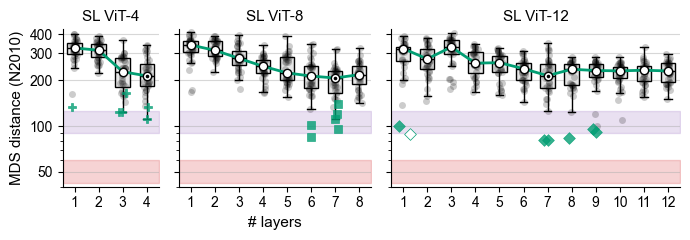

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(7, 2.5), sharey='row', width_ratios=[1, 2, 3], tight_layout=True)
#fig.suptitle("All data")
#for i, tm in enumerate(training_methods):
i = 1#1
tm = training_methods[1]#0]
for j, depth in enumerate(depth_list):
    dist_mat = mds_dist_flatten_dict[tm][str(depth)]
    #dist_mat_min = np.min(dist_mat, axis=2)
    columns = [str(d+1) for d in range(depth)]
    df = pd.DataFrame(dist_mat, columns=columns)#, columns=np.array2string(np.arange(1, depth+1)))
    df_melt = df.melt()
    vit_min_indices = df_melt["value"].isin(mds_dist_min_dict[tm][str(depth)])
    #vit_min_indices = df_melt["value"].isin(mds_dist_groups_dict[f"{tm}_{depth}"])
    
    
    #sns.stripplot(data=df, jitter=True, linewidth=1, edgecolor='k', palette=colors[i], ax=axes[j])
    #axes[j].grid(linestyle='--', linewidth=1)
    dist_median = np.median(dist_mat, axis=0)
    dist_median_minidx = np.argmin(dist_median)
    #axes[j].arrow(dist_median_minidx, dist_mat[:, dist_median_minidx].max()+90, 0, -30, 
    #                 head_width=0.2, head_length=20, color="tab:red", zorder=999, clip_on=False)
    #sns.pointplot(data=df_melt, x="variable", y="value", estimator='median', ax=axes[j], 
    #              color=cmaps[i](0.2*(j+2)), errorbar=("pi", 50), linewidth=2, zorder=9)#showfliers=False, color="white", width=0.6, 
    #axes[j].scatter(np.arange(0, len(dist_median)), dist_median, color="white", marker="o", s=6, zorder=10)
    axes[j].scatter(dist_median_minidx, dist_median[dist_median_minidx], color="k", marker=".", s=10, zorder=11)

    sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color="0.9", width=0.6, 
                ax=axes[j], linecolor="k")
    #sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color=model_colors[i][j], width=0.6, 
    #            ax=axes[j])
    axes[j].plot(np.arange(0, len(dist_median)), dist_median, color=model_colors[i][j], 
                    linewidth = 2.0, marker="o", ms=6, mec="k", mfc="white", zorder=10)
    sns.stripplot(data=df_melt[~vit_min_indices], x="variable", y="value", color="k", alpha=0.2, ax=axes[j], rasterized=False)
    axes[j].scatter(df_melt[vit_min_indices]["variable"].to_numpy().astype(float) -1 + (np.random.rand(num_models)-0.5)/3, 
                       df_melt[vit_min_indices]["value"].to_numpy().astype(float), 
                       marker=model_markers[j], facecolor=model_colors[i][j], linewidth=0.5, alpha=0.8, zorder=3, 
                       label="Model-best heads")
    official_min_idx = np.where(mds_dist_dict[f"{tm}_deit_small16"] == mds_dist_min_dict[f"{tm}_deit_small16"])[0]
    if j == 2:
        axes[j].scatter(official_min_idx+0.3, mds_dist_min_dict[f"{tm}_deit_small16"], 
                           ec=model_colors[i][j], fc="white", linewidth=0.5, marker="D", alpha=1, zorder=5, label="Official model-best heads")
    if tm == "dino":
        tm_ = "DINO ViT-"
    else:
        tm_ = "SL ViT-"
    axes[j].set_title(f"{tm_}{depth}", fontsize=11)
    #xes[j].axhline(subj_mean_dist, linestyle="dashed", color="tab:red", label="Dist. between subjects")
    #if i == 0 and j == 2:
    #    axes[j].legend()
    axes[j].minorticks_on()
    axes[j].grid(which='major', alpha=0.5, axis="y")
    #axes[j].grid(which='minor', alpha=0.5, linestyle='--', axis="y")
    axes[j].xaxis.set_tick_params(which='minor', bottom=False)
    axes[j].set_yscale('log')
    #axes[j].set_ylim(20, )# 450)
    axes[j].set_xlim(-0.5, depth-0.5)
    axes[j].set_ylim(40, )
    axes[j].set_xlabel("")
    axes[j].set_ylabel("")
    axes[j].fill_between([-0.5, depth-0.5], 
                    np.percentile(df_mds_dist_groups["TD adults"].dropna().values, 25),
                    np.percentile(df_mds_dist_groups["TD adults"].dropna().values, 75),
                    color=color_list[0], alpha=0.2, label="TD adults IQR", zorder=-1)
    axes[j].fill_between([-0.5, depth-0.5], 
                    np.percentile(df_mds_dist_groups["ASD children"].dropna().values, 25),
                    np.percentile(df_mds_dist_groups["ASD children"].dropna().values, 75),
                    color=color_list[3], alpha=0.2, label="ASD children IQR", zorder=-1)        
#axes[0, 2].legend(ncol=2, handletextpad=0, prop={'size': 9}, borderpad=0.3, labelspacing=0.1)
axes[0].yaxis.set_major_formatter(ScalarFormatter())
axes[0].set_yticks([50, 100,200, 300, 400])
axes[1].set_xlabel("# layers", fontsize=11)
axes[0].set_ylabel("MDS distance (N2010)", fontsize=11)
plt.savefig("../figures/MDS_dist_layers_N2010_sl.svg", dpi=300, bbox_inches="tight")
#plt.savefig("../figures/MDS_dist_layers_N2010_sl.svg", dpi=300, bbox_inches="tight")
fig.align_labels()
fig.show()